<a href="https://colab.research.google.com/github/sqiprasanna/climate_change_tweets_sentiment_analysis/blob/main/SVG_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np
import pandas as pd
import spacy
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
from itertools import chain
from wordcloud import WordCloud, STOPWORDS 
# !pip install xlrd==1.2.0
import cufflinks as cf
import regex as re
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
# !pip install xlrd==1.2.0

In [116]:
# data = pd.read_csv('/content/1377884570_tweet_global_warming.csv',encoding="unicode_escape",engine="python")
data = pd.read_csv('1377884570_tweet_global_warming.csv',encoding="unicode_escape",engine="python")

data.head()



,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [117]:
# from google.colab import drive
# drive.mount('/content/drive')

In [118]:
print(data['existence'].value_counts())


Y      2554
N      1053
Yes     557
No       61
Name: existence, dtype: int64


In [119]:
data['word_count'] = data['tweet'].apply(lambda x: len(x.split(" ")))
data = data.drop_duplicates()
data = data.dropna()
data.loc[data['existence'] == 'Y','existence'] = "Yes"
data.loc[data['existence'] == 'N','existence'] = "No"
print(data.shape)
data.dropna()
data.loc[data['existence'] == np.nan,'existence'] = "No"
print(data['existence'].value_counts())
print(data.shape)
data.head()

(4134, 4)
Yes    3029
No     1105
Name: existence, dtype: int64
(4134, 4)


,tweet,existence,existence.confidence,word_count
0,Global warming report urges governments to act...,Yes,1.0000,18
1,Fighting poverty and global warming in Africa ...,Yes,1.0000,8
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786,12
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000,12
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087,11


In [120]:
tweets = data["tweet"]
tweets

0       Global warming report urges governments to act...
1       Fighting poverty and global warming in Africa ...
2       Carbon offsets: How a Vatican forest failed to...
3       Carbon offsets: How a Vatican forest failed to...
4       URUGUAY: Tools Needed for Those Most Vulnerabl...
                              ...                        
6084    It's 83_Á and climbing in NYC. August weather...
6085    @bloodless_coup "The phrase 'global warming' s...
6087    Global warming you tube parody you will enjoy ...
6088    One-Eyed Golfer: Don't dare tell me about glob...
6089    man made global warming a hair brained theory ...
Name: tweet, Length: 4134, dtype: object

For Preprocessing we have used

In [121]:
### Source: https://spacy.io/usage/linguistic-features

def spacyPipeline(tweets):
    nlp = spacy.load('en_core_web_sm')
    
    MIN_TWEET_LEN = 5
    
    indices = []
    preprocessed_tweets = []
    for index, t in enumerate(tweets):
        
        doc = nlp(t)
        filtered_tweet = set()
        
        for token in doc:
            # print(token, " | ", spacy.explain(token.pos_))
            if (token.lemma_ not in filtered_tweet) and checkWord(token):
                filtered_tweet.add(token.lemma_.lower())
        
        if len(filtered_tweet) >= MIN_TWEET_LEN:
            print(filtered_tweet,"\n---\n")
            preprocessed_tweets.append(filtered_tweet)
            indices.append(index)
    
    return preprocessed_tweets, indices

count no of mentions in each tweet

In [122]:
pattern=r'@\w+'
count_mentions = tweets.apply(lambda tweet: len(re.findall(pattern, tweet)))
count_mentions

0       0
1       0
2       0
3       0
4       0
       ..
6084    0
6085    1
6087    0
6088    0
6089    0
Name: tweet, Length: 4134, dtype: int64

count no of hashtags in each tweet

In [123]:
pattern=r'#\w+'
print(tweets)
count_hashtags = tweets.apply(lambda tweet: len(re.findall(pattern, tweet)))
print(count_hashtags)


0       Global warming report urges governments to act...
1       Fighting poverty and global warming in Africa ...
2       Carbon offsets: How a Vatican forest failed to...
3       Carbon offsets: How a Vatican forest failed to...
4       URUGUAY: Tools Needed for Those Most Vulnerabl...
                              ...                        
6084    It's 83_Á and climbing in NYC. August weather...
6085    @bloodless_coup "The phrase 'global warming' s...
6087    Global warming you tube parody you will enjoy ...
6088    One-Eyed Golfer: Don't dare tell me about glob...
6089    man made global warming a hair brained theory ...
Name: tweet, Length: 4134, dtype: object
0       0
1       0
2       0
3       0
4       0
       ..
6084    0
6085    2
6087    2
6088    0
6089    3
Name: tweet, Length: 4134, dtype: int64


count no of links in each tweet

In [124]:
pattern=r'http.?://[^\s]+[\s]?'
count_urls = tweets.apply(lambda tweet: len(re.findall(pattern, tweet)))

In [125]:
#print the total number of hashtags, mentions and urls.

In [126]:
print("Mentions:",count_mentions.sum())
print("Hashtags:",count_hashtags.sum())
print("Urls:",count_urls.sum())



Mentions: 1536
Hashtags: 1551
Urls: 2699


In [127]:
def splitWords(t):
    splitTweet = []
    t = t.split(' ')
    
    for word in t:
        res = re.search(r'[A-Z]', word)
        if res is not None:
            ch = word[res.span()[0]]
            words = re.split(r'[A-Z]', word)
            splitTweet.extend([words[0], ch + words[1]])
        else:
            splitTweet.extend(re.split(r'["|,;!|:*]', word))
    
    return ' '.join(splitTweet)

In [128]:
def checkWord(token):
    negations = ['not', 'no']
    fillers = ['link', 'http']
    return (not token.is_stop) and (token.is_alpha) and (token.text not in fillers) and ((token.text in negations) or (len(token.text) > 3))

In [129]:
def preprocess(tweets):

    whiteList=['climate','change','earth','global','warming','planet']

    #Remove mentions
    count=0
    mentions_tweets = [re.findall('@\w+', tweet) for tweet in tweets]

    #Remove hash sign
    hash_tweets = [re.findall('#\w+', tweet) for tweet in tweets]

    #Remove urls
    urls_tweets = [re.findall(r'http.?://[^\s]+[\s]?', tweet) for tweet in tweets]


    #Convert all to lowercase
    tweets = [t.lower() for t in tweets]
    
    # Process tweets through spaCy pipeline
    tweets, indices = spacyPipeline(tweets)
    
    # print(tweets)
    return tweets,hash_tweets,urls_tweets,mentions_tweets,indices
  

In [130]:
def generateWordCloud(tweets):
    allwords = " ".join(set(chain.from_iterable(tweets)))
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = set(STOPWORDS), 
                    min_font_size = 10).generate(allwords)

    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 

    plt.show()

In [131]:
preprocessed_tweets,hash_tweets,urls_tweets,mentions_tweets,indices_pre = preprocess(tweets)
# preprocessed_tweets

Streaming output truncated to the last 5000 lines.
---

{'climate', 'exist', 'summer', 'winter', 'spring', 'change', 'fall', 'justsaye'} 
---

{'obama', 'global', 'blast', 'snow', 'warming', 'snobama', 'ipcc', 'rate', 'star', 'video', 'youtube'} 
---

{'climate', 'thing', 'industry', 'easi', 'take', 'change', 'mail', 'come', 'curb', 'seattle', 'junk'} 
---

{'global', 'tcot', 'blizzard', 'little', 'warming', 'inhofe', 'gore', 'family', 'expense'} 
---

{'great', 'global', 'tcot', 'warming', 'collapse'} 
---

{'global', 'want', 'yeah', 'carbon', 'increase', 'warming', 'footprint'} 
---

{'sore', 'global', 'feel', 'snow', 'foot', 'dig', 'warming'} 
---

{'climate', 'global', 'consensus', 'fast', 'change', 'bogus', 'warming', 'fade'} 
---

{'obama', 'cover', 'global', 'climategate', 'tcot', 'hand', 'snow', 'washington', 'promise', 'warming', 'year'} 
---

{'global', 'report', 'expose', 'claim', 'ipcc', 'false', 'warming', 'hysteria'} 
---

{'global', 'fail', 'warming', 'power', 'beer'} 
-

Checking after prepocessing hashtags and urls 

In [132]:
pattern='@\w+'
# count_hashtags = preprocessed_tweets.apply(lambda tweet: len(re.findall(pattern, tweet)))
count_hashtags = [len(re.findall(pattern," ".join(t))) for t in preprocessed_tweets]
sum(count_hashtags)

0

In [133]:
pattern=r'http.?://[^\s]+[\s]?'
# count_urls = tweets.apply(lambda tweet: len(re.findall(pattern, tweet)))
count_urls = [len(re.findall(pattern," ".join(t))) for t in preprocessed_tweets]
sum(count_urls)

0

In [134]:
print(sum(count_hashtags))


0


## VISUALIZATIONS
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

https://github.com/yrtnsari/Sentiment-Analysis-NLP-with-Python/blob/main/wordcloud.ipynb


In [135]:

pos_tweets=data[data['existence']=='Yes']
pos_tweets.head()

,tweet,existence,existence.confidence,word_count
0,Global warming report urges governments to act...,Yes,1.0000,18
1,Fighting poverty and global warming in Africa ...,Yes,1.0000,8
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786,12
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000,12
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087,11


In [136]:

data_pos=data[data['existence']=='Yes']
hashtags = data_pos["tweet"].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() ))).sum(axis=0).to_frame().reset_index().sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

In [137]:
hashtags.head(10)

,hashtag,occurences
58,#climate,138.0
245,#tcot,69.0
119,#green,47.0
188,#p2,47.0
60,#climatechange,36.0
209,#saveterra,31.0
76,#earthday,24.0
80,#eco,23.0
113,#global,18.0
114,#globalwarming,15.0


In [138]:

data_pos_mentions=data[data['existence']=='Yes']
mentions = data_pos_mentions["tweet"].apply(lambda x: pd.value_counts(re.findall('(@\w+)', x.lower() ))).sum(axis=0).to_frame().reset_index().sort_values(by=0,ascending=False)
mentions.columns = ['mentions','occurences']

In [139]:
mentions.head(10)

,mentions,occurences
411,@newsongreen,30.0
93,@change,22.0
569,@time,14.0
284,@humanitynews,11.0
581,@treehugger,10.0
389,@mmfa,9.0
469,@qorianka,8.0
412,@newsweek,8.0
252,@greenforyou,7.0
303,@invasivenotes,7.0


In [140]:

data_neg=data[data['existence']=='No']
hashtags = data_neg["tweet"].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() ))).sum(axis=0).to_frame().reset_index().sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

In [141]:
hashtags.head(10)

,hashtag,occurences
123,#tcot,118.0
93,#p2,38.0
23,#climate,36.0
124,#teaparty,25.0
49,#global,18.0
25,#climategate,18.0
53,#gop,16.0
113,#sgp,15.0
127,#tlot,10.0
92,#ocra,10.0


In [142]:
data_neg_mentions=data[data['existence']=='No']
mentions_neg = data_neg["tweet"].apply(lambda x: pd.value_counts(re.findall('(@\w+)', x.lower() ))).sum(axis=0).to_frame().reset_index().sort_values(by=0,ascending=False)
mentions_neg.columns = ['mentions','occurences']

In [143]:
mentions_neg.head(10)

,mentions,occurences
14,@algore,10.0
96,@drudge_report,8.0
233,@newtgingrich,7.0
259,@redostoneage,7.0
8,@addthis,7.0
212,@mattyglesias,7.0
289,@stephenathome,5.0
124,@globeandmail,5.0
231,@newsbusters,4.0
72,@cubachi,4.0


Collect the positive tweets that contain hashtags

In [144]:
pre_tweet_pos,pos_hash_tweets,pos_urls_tweets,pos_mentions_tweets,indices_pos=preprocess(pos_tweets.tweet)

Streaming output truncated to the last 5000 lines.
---

{'big', 'climate', 'problem', 'freeride', 'change', 'barrett', 'action'} 
---

{'black', 'global', 'people', 'world', 'coal', 'mine', 'warming'} 
---

{'climate', 'price', 'bolivia', 'change', 'people', 'put', 'world', 'kick', 'cochabamba', 'conference'} 
---

{'climate', 'tool', 'crunch', 'supercomputer', 'nasa', 'data', 'change', 'aim', 'earth', 'launch', 'time'} 
---

{'kandi', 'climate', 'lili', 'kari', 'bolivia', 'change', 'people', 'world', 'friend', 'conference'} 
---

{'global', 'volcano', 'angry', 'warming', 'iceland'} 
---

{'climate', 'mother', 'right', 'greenpeace', 'change', 'people', 'wave', 'world', 'make', 'earth', 'conference'} 
---

{'global', 'country', 'danger', 'official', 'agree', 'break', 'stop', 'warming', 'process', 'collapse'} 
---

{'mean', 'global', 'scientist', 'thing', 'cause', 'rise', 'justin', 'foot', 'world', 'ocean', 'biebe', 'warming'} 
---

{'mean', 'global', 'scientist', 'thing', 'cause', 'rise

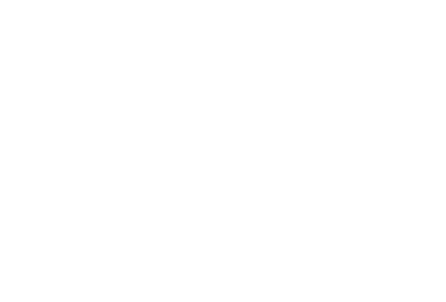

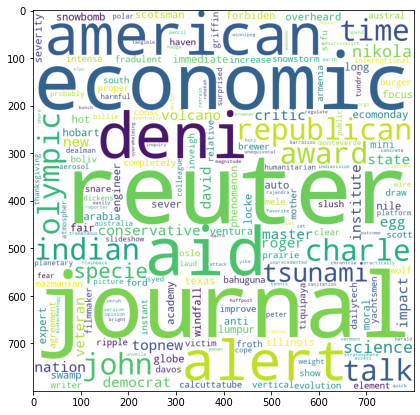

In [145]:
generateWordCloud(pre_tweet_pos)

Negative tweets visualization

In [146]:

neg_tweets=data[data['existence']=='No']
neg_tweets.head()

,tweet,existence,existence.confidence,word_count
17,Wait here's an idea: it's natural climate chan...,No,0.6648,14
31,@New_federalists i have it on good auth tht g...,No,0.8197,27
32,Illegal war and the myth of global warming|My ...,No,0.9183,20
33,the scientific community was scamed by global ...,No,0.9336,12
35,40 degrees in NYC. please urinate on next libe...,No,1.0000,16


In [147]:
pre_tweet_neg,neg_hash_tweets,neg_urls_tweets,neg_mentions_tweets,indices_neg=preprocess (neg_tweets.tweet)

{'wait', 'climate', 'global', 'idea', 'natural', 'change', 'induce', 'warming', 'human'} 
---

{'global', 'tcot', 'cause', 'good', 'fungus', 'fortunate', 'warming', 'auth'} 
---

{'illegal', 'global', 'main', 'platform', 'campaign', 'election', 'myth'} 
---

{'global', 'scam', 'community', 'scientific', 'warming', 'green'} 
---

{'global', 'scum', 'liberal', 'change', 'degree', 'urinate', 'warming'} 
---

{'global', 'ocra', 'ucot', 'mississippi', 'tornado', 'tornadocot', 'tlot', 'warm', 'tycot', 'gore', 'race'} 
---

{'global', 'scam', 'settle', 'confirm', 'stop', 'book', 'warming', 'sussman'} 
---

{'global', 'believe', 'angel', 'exist', 'cause', 'jesus', 'tcot', 'miracle', 'rationalist', 'alien', 'fairy', 'warming', 'human'} 
---

{'climate', 'killer', 'tsunami', 'peruvian', 'change', 'lake', 'proof', 'glaci', 'fall', 'fracture', 'create'} 
---

{'climate', 'global', 'hack', 'hoax', 'warming', 'change', 'palin', 'real', 'algore', 'science', 'gore'} 
---

{'journal', 'global', 'scient

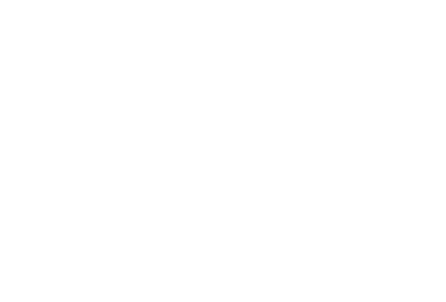

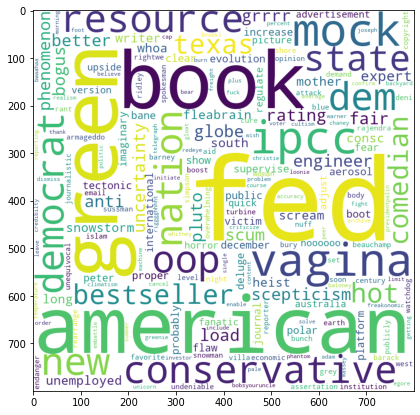

In [148]:
generateWordCloud(pre_tweet_neg)

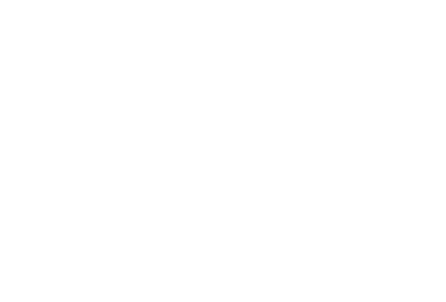

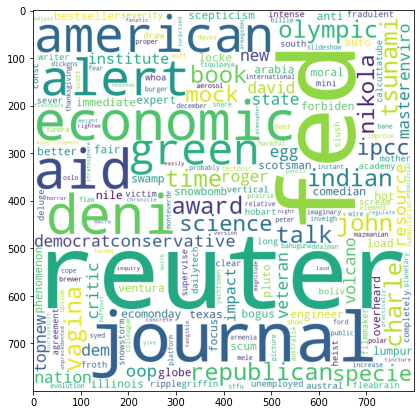

In [149]:
# generateWordCloud([t.split(' ') for t in tweets])
generateWordCloud(preprocessed_tweets)

In [150]:
import nltk
preprocessed_tweets
flat_list = []
for sublist in preprocessed_tweets:
    for item in sublist:
        flat_list.append(item)

In [151]:
bigrams_series = (pd.Series(nltk.ngrams(flat_list, 2)).value_counts())[:10]

Text(0.5, 0, 'Number of Occurances')

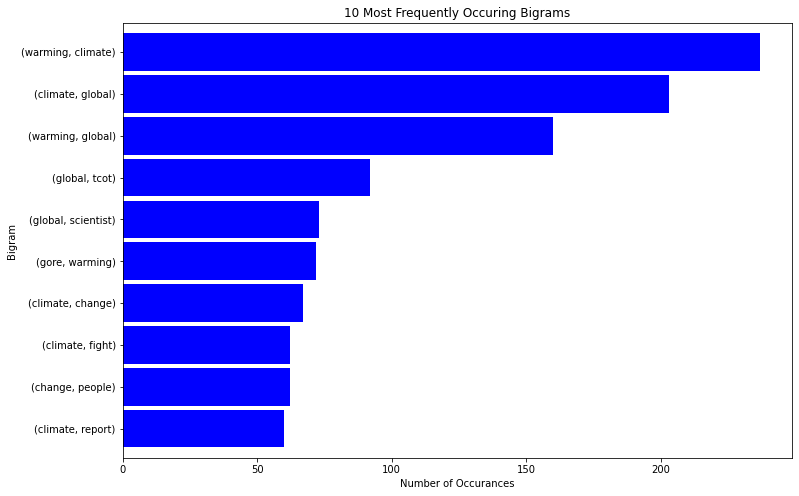

In [152]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

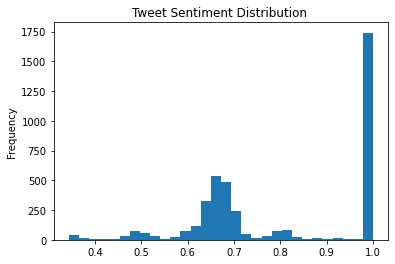

In [153]:
data['existence.confidence'].plot(
    kind='hist',
    bins=30,
    title='Tweet Sentiment Distribution ')

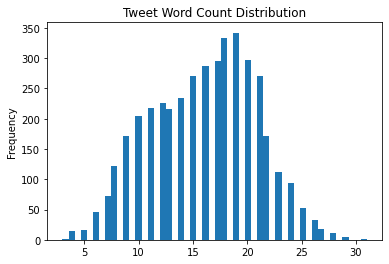

In [154]:
data['word_count'].plot(
    kind='hist',
    # xTitle = "Word Count",
    bins=50,
    title='Tweet Word Count Distribution')

           existence.confidence  word_count
existence                                  
No                     840.8694       18845
Yes                   2474.1951       47302


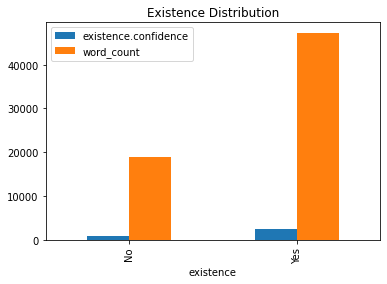

In [155]:
print(data.groupby(by=["existence"]).sum())
data.groupby(by=["existence"]).sum().plot(kind = 'bar',title = "Existence Distribution")

global 2437
warming 2360
climate 2355
change 2155
link 489
retwt 218
snow 217
tcot 187
news 177
science 162
oohja 158
green 150
will 149
earth 131
world 130
report 129
gore 112
time 103
scientists 102
energy 102


,tweet,word_count
0,global,2437
1,warming,2360
2,climate,2355
3,change,2155
4,link,489


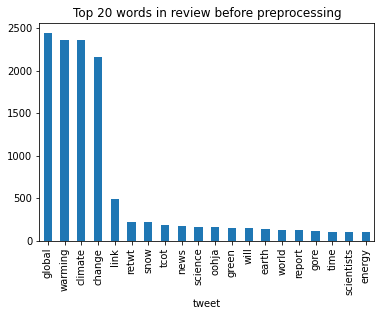

In [156]:
# The distribution of top unigrams before removing stop words
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if len(word) > 3 and word not in set(STOPWORDS)]
    # words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['tweet'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'word_count'])
display(df1.head())

df1.groupby('tweet').sum()['word_count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before preprocessing')



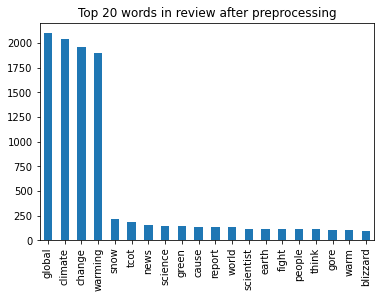

In [157]:
allwords = list(chain.from_iterable(preprocessed_tweets))
df2 = pd.DataFrame(allwords,columns = ["words"])
df2['words'].value_counts()[:20].plot(kind='bar', title='Top 20 words in review after preprocessing')
# allwords
# preprocessed_tweets

In [158]:
data.head()

,tweet,existence,existence.confidence,word_count
0,Global warming report urges governments to act...,Yes,1.0000,18
1,Fighting poverty and global warming in Africa ...,Yes,1.0000,8
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786,12
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000,12
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087,11


In [159]:
prepr_tweets = [" ".join(each) for each in preprocessed_tweets]
data_new=data.iloc[indices_pre]
data_new['cleaned_tweet'] = prepr_tweets
data_new.head()

,tweet,existence,existence.confidence,word_count,cleaned_tweet
0,Global warming report urges governments to act...,Yes,1.0000,18,report global government urge world hunger inc...
1,Fighting poverty and global warming in Africa ...,Yes,1.0000,8,global fight africa poverty warming
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786,12,global reduce fail vatican forest warming carb...
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000,12,global reduce fail vatican forest warming carb...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087,11,climate tool uruguay vulnerable change need


In [160]:
len(prepr_tweets), data.shape

(3865, (4134, 4))

## TF IDF & modelling

In [161]:
# TF IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split,cross_validate
import collections, numpy
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [162]:
data.isna().sum()


tweet                   0
existence               0
existence.confidence    0
word_count              0
dtype: int64

In [163]:
X_train, X_test, y_train, y_test_nb= train_test_split(data_new.cleaned_tweet,data_new['existence'], test_size=0.2, random_state=33)

Use MultinomialNB

In [164]:
model_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_nb.fit(X_train, y_train)
predicted_categories_NB = model_nb.predict(X_test)

Create apickle file for webapp

In [165]:
import pickle
pickle.dump(model_nb,open("model.pkl",'wb'))

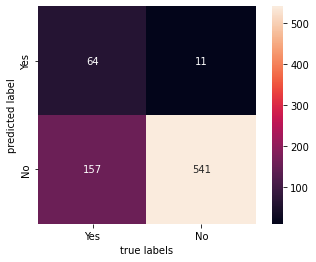

The testing accuracy is 0.7826649417852523
The training accuracy is 0.869340232858991


In [166]:
# plot the confusion matrix
mat = confusion_matrix(y_test_nb, predicted_categories_NB)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=y_train.unique(),yticklabels=y_train.unique())
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The testing accuracy is {}".format(accuracy_score(y_test_nb, predicted_categories_NB)))
print("The training accuracy is {}".format(accuracy_score(y_train, model_nb.predict(X_train))))

In [167]:
#Cross Validation Score

In [168]:
from sklearn.model_selection import cross_val_score
scores_Naive_Bayes = cross_val_score(model_nb, data_new.cleaned_tweet,data_new['existence'], cv=10, scoring="accuracy")
print(scores_Naive_Bayes)
meanScore = scores_Naive_Bayes.mean()
print(meanScore * 100)

[0.81136951 0.77777778 0.80361757 0.74418605 0.77002584 0.7746114
 0.74611399 0.75388601 0.79792746 0.77202073]
77.51536329678275


Random Forest Imbalanced classes

In [169]:
X_train, X_test, y_train, y_test = train_test_split(data_new.cleaned_tweet,data_new['existence'], test_size=0.3, random_state=33)

In [170]:
from sklearn.ensemble import RandomForestClassifier
model_random_forest = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
model_random_forest.fit(X_train, y_train)
predicted_categories_random_forest = model_random_forest.predict(X_test)

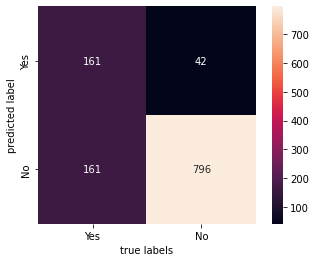

The testing accuracy is 0.825
The training accuracy is 0.9866913123844732


In [171]:
# plot the confusion matrix
mat = confusion_matrix(y_test, predicted_categories_random_forest)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=y_train.unique(),yticklabels=y_train.unique())
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The testing accuracy is {}".format(accuracy_score(y_test, predicted_categories_random_forest)))
print("The training accuracy is {}".format(accuracy_score(y_train, model_random_forest.predict(X_train))))

In [172]:
scores_random_forest = cross_val_score(model_random_forest, data_new.cleaned_tweet,data_new['existence'], cv=10, scoring="accuracy")
print(scores_random_forest)
meanScore = scores_random_forest.mean()
print(meanScore * 100)

[0.88113695 0.82945736 0.84237726 0.79069767 0.77777778 0.77720207
 0.71761658 0.79792746 0.79792746 0.78756477]
79.99685370392685


Comparisions between models

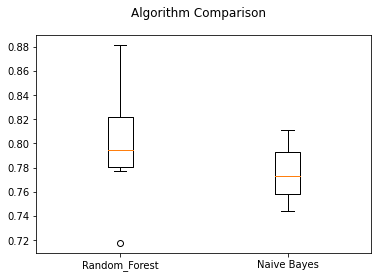

In [173]:
results=[]
names=[]
results.append(scores_random_forest)
names.append("Random_Forest")


results.append(scores_Naive_Bayes)
names.append("Naive Bayes")



# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [174]:
 from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [175]:
accu_rf=round(accuracy_score(y_test,predicted_categories_random_forest),3)
f1_score_rf=round(f1_score(y_test,predicted_categories_random_forest,average="binary",pos_label="Yes"), 3)
Precision_rf=round(precision_score(y_test,predicted_categories_random_forest,average="binary",pos_label="Yes"),3)
Recall_rf=round(recall_score(y_test,predicted_categories_random_forest,average="binary",pos_label="Yes"),3)
print('Accuracy:',accu_rf)
print('F1_Score:',f1_score_rf)
print('Recall_Score:',Precision_rf)
print('Precision_Score:',Recall_rf)

Accuracy: 0.825
F1_Score: 0.887
Recall_Score: 0.832
Precision_Score: 0.95


In [176]:
accu_nb=round(accuracy_score(y_test_nb,predicted_categories_NB),3)
f1_score_nb=round(f1_score(y_test_nb,predicted_categories_NB,average="binary",pos_label="Yes"),3)
Precision_nb=round(precision_score(y_test_nb,predicted_categories_NB,average="binary",pos_label="Yes"),3)
Recall_nb=round(recall_score(y_test_nb,predicted_categories_NB,average="binary",pos_label="Yes"),3)
print('Accuracy:',accu_nb)
print('F1_Score:',f1_score_nb)
print('Recall_Score:',Precision_nb)
print('Precision_Score:',Recall_nb)

Accuracy: 0.783
F1_Score: 0.866
Recall_Score: 0.775
Precision_Score: 0.98


In [177]:
Result_2={
                  'Model':['Random-Forest','Naive Bayes'],
                  'Accuracy(%)':[accu_rf*100,accu_nb*100],
                  'F1_Score(%)':[f1_score_rf*100,f1_score_nb*100],
                  'Precision(%)':[Precision_rf*100,Precision_nb*100],
                  'Recall(%)':[Recall_rf*100,Recall_nb*100]
        
                    }
Result_final=pd.DataFrame(Result_2)

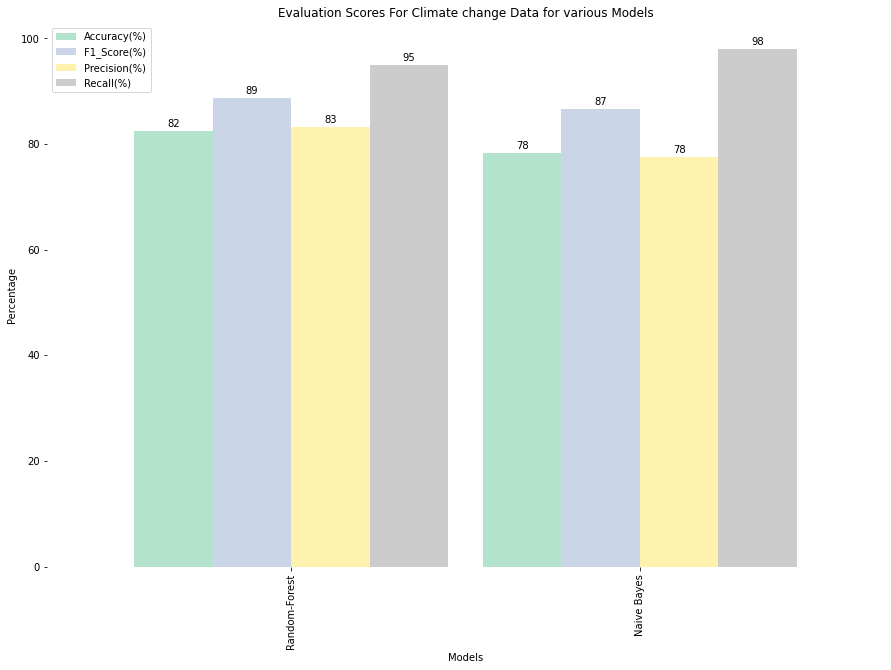

In [178]:
splot=Result_final.plot(x='Model',y=['Accuracy(%)','F1_Score(%)','Precision(%)','Recall(%)'],kind='bar',figsize=(15,10),cmap='Pastel2',width=0.9)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0,7),
                   textcoords='offset points')
plt.title('Evaluation Scores For Climate change Data for various Models for imbalanced classes')
plt.ylabel('Percentage')
plt.xlabel('Models')
plt.legend(loc='upper left')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

In [179]:
# performing random over sampling to reduce the imbalance in classes 
from imblearn.over_sampling import RandomOverSampler

In [209]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
tf = TfidfVectorizer()
transf_text= tf.fit_transform(data_new['cleaned_tweet'].astype('U'))
transf_text_rf= TruncatedSVD(n_components=2500).fit_transform(transf_text)
transf_text_rf2= TruncatedSVD(n_components=2000).fit_transform(transf_text)
cos_sim=cosine_similarity(transf_text, transf_text)
cos_sim_rf=cosine_similarity(transf_text_rf, transf_text_rf)
cos_sim_rf2=cosine_similarity(transf_text_rf2, transf_text_rf2)
print(cos_sim)


[[1.         0.03091766 0.02065754 ... 0.01956034 0.0190495  0.01513498]
 [0.03091766 1.         0.03703929 ... 0.035072   0.03415605 0.02713727]
 [0.02065754 0.03703929 1.         ... 0.02343325 0.02282126 0.01813168]
 ...
 [0.01956034 0.035072   0.02343325 ... 1.         0.02160914 0.01716864]
 [0.0190495  0.03415605 0.02282126 ... 0.02160914 1.         0.01672026]
 [0.01513498 0.02713727 0.01813168 ... 0.01716864 0.01672026 1.        ]]


Applying naive Bayes for Balanced classes

In [181]:
X_train_nb_bal, X_test_nb_bal, y_train_nb_bal, y_test_nb_bal= train_test_split(cos_sim,data_new['existence'], test_size=0.2, random_state=33)

In [182]:
X_train_nb_bal.shape

(3092, 3865)

In [183]:
X_train_nb_bal,y_train_nb_bal = RandomOverSampler(random_state = 21).fit_resample(X_train_nb_bal,y_train_nb_bal)

In [184]:
X_train_nb_bal.shape, y_train_nb_bal.shape

((4596, 3865), (4596,))

In [185]:
model_nb_bal = make_pipeline(MultinomialNB())
model_nb_bal.fit(X_train_nb_bal, y_train_nb_bal)
predicted_categories_NB_bal = model_nb_bal.predict(X_test_nb_bal)

{'fit_time': array([0.24626422, 0.46874404, 0.22692871, 0.26259041, 0.29134798,
       0.43924904, 0.34680676, 0.39342833, 0.48493624, 0.51299548]), 'score_time': array([0.08455467, 0.10489035, 0.03358936, 0.04312181, 0.0499773 ,
       0.07850528, 0.10062432, 0.05822158, 0.08234596, 0.08766317]), 'test_accuracy': array([0.65      , 0.64565217, 0.64347826, 0.63695652, 0.69565217,
       0.63043478, 0.62962963, 0.62527233, 0.63180828, 0.65577342]), 'train_accuracy': array([0.64337524, 0.64410058, 0.64482592, 0.64555126, 0.63878143,
       0.64555126, 0.64563693, 0.64612038, 0.64515349, 0.64273628]), 'test_precision': array([0.66829268, 0.657277  , 0.68131868, 0.66666667, 0.71634615,
       0.64705882, 0.64018692, 0.6407767 , 0.65625   , 0.67661692]), 'train_precision': array([0.6637217 , 0.66518847, 0.66357182, 0.66520307, 0.65856354,
       0.66611479, 0.66703663, 0.66685083, 0.66483818, 0.66280992]), 'test_recall': array([0.59565217, 0.60869565, 0.53913043, 0.54782609, 0.64782609,
   

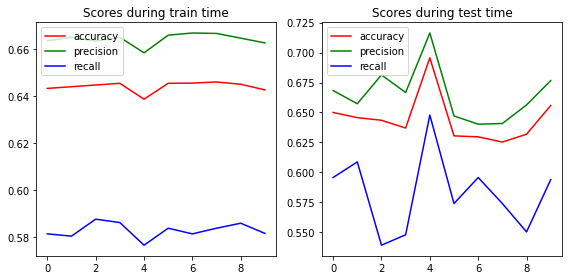

,accuracy,precision,recall,f1_macro
train,0.644183,0.664390,0.582729,0.642833
test,0.644466,0.665079,0.582671,0.642916


In [205]:
cv_NB, mean_scores_NB = cross_val(X_train_nb_bal, y_train_nb_bal, X_test_nb_bal, y_test_nb_bal, MultinomialNB() )
print(cv_NB)
plot_cross_val(cv_NB)
mean_scores_NB

In [ ]:
accu_nb_bal=round(accuracy_score(y_test_nb_bal,predicted_categories_NB_bal),3)
f1_score_nb_bal=round(f1_score(y_test_nb_bal,predicted_categories_NB_bal,average="binary",pos_label="Yes"),3)
Precision_nb_bal=round(precision_score(y_test_nb_bal,predicted_categories_NB_bal,average="binary",pos_label="Yes"),3)
Recall_nb_bal=round(recall_score(y_test_nb_bal,predicted_categories_NB_bal,average="binary",pos_label="Yes"),3)
print('Accuracy:',accu_nb_bal)
print('F1_Score:',f1_score_nb_bal)
print('Recall_Score:',Precision_nb_bal)
print('Precision_Score:',Recall_nb_bal)

Random Sampling Over sampler for Random Forest

In [202]:
 X_train_rf_bal, X_test_rf_bal, y_train_rf_bal, y_test_rf_bal= train_test_split(cos_sim_rf,data_new['existence'], test_size=0.2, random_state=33)

In [203]:
X_train_rf_bal,y_train_rf_bal = RandomOverSampler(random_state = 21).fit_resample(X_train_rf_bal,y_train_rf_bal)

In [204]:
model_random_forest = make_pipeline(RandomForestClassifier())
model_random_forest.fit(X_train_rf_bal, y_train_rf_bal)
predicted_categories_random_forest_bal = model_random_forest.predict(X_test_rf_bal)

In [ ]:
cv_RF, mean_scores_RF = cross_val(X_train_nb_bal, y_train_nb_bal, X_test_nb_bal, y_test_nb_bal, RandomForestClassifier() )
print(cv_RF)
plot_cross_val(cv_RF)
mean_scores_RF

In [ ]:
accu_rf=round(accuracy_score(y_test_rf_bal,predicted_categories_random_forest_bal),3)
f1_score_rf=round(f1_score(y_test_rf_bal,predicted_categories_random_forest_bal,average="binary",pos_label="Yes"), 3)
Precision_rf=round(precision_score(y_test_rf_bal,predicted_categories_random_forest_bal,average="binary",pos_label="Yes"),3)
Recall_rf=round(recall_score(y_test_rf_bal,predicted_categories_random_forest_bal,average="binary",pos_label="Yes"),3)
print('Accuracy:',accu_rf)
print('F1_Score:',f1_score_rf)
print('Recall_Score:',Precision_rf)
print('Precision_Score:',Recall_rf)

In [ ]:
Result_2={
                  'Model':['Random-Forest','Naive Bayes'],
                  'Accuracy(%)':[accu_rf*100,accu_nb_bal*100],
                  'F1_Score(%)':[f1_score_rf*100,f1_score_nb_bal*100],
                  'Precision(%)':[Precision_rf*100,Precision_nb_bal*100],
                  'Recall(%)':[Recall_rf*100,Recall_nb_bal*100]
        
                    }
Result_final=pd.DataFrame(Result_2)

In [ ]:
splot=Result_final.plot(x='Model',y=['Accuracy(%)','F1_Score(%)','Precision(%)','Recall(%)'],kind='bar',figsize=(15,10),cmap='Pastel2',width=0.9)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0,7),
                   textcoords='offset points')
plt.title('Evaluation Scores For Climate change Data for various Models for balanced classes')
plt.ylabel('Percentage')
plt.xlabel('Models')
plt.legend(loc='upper left')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

SVD

In [206]:

X_train_rf_bal, X_test_rf_bal, y_train_rf_bal, y_test_rf_bal= train_test_split(cos_sim_rf,data_new['existence'], test_size=0.2, random_state=33)

In [207]:
X_train_rf_bal,y_train_rf_bal = RandomOverSampler(random_state = 21).fit_resample(X_train_rf_bal,y_train_rf_bal)

{'fit_time': array([40.49316573, 40.82385516, 41.12343121, 40.05252051, 38.14345646,
       38.75400305, 38.105124  , 39.45802617, 40.99021649, 39.02043509]), 'score_time': array([0.08402944, 0.09221411, 0.07050705, 0.07148886, 0.07707357,
       0.07246113, 0.07974434, 0.07608986, 0.06957531, 0.0449903 ]), 'test_accuracy': array([0.89347826, 0.92826087, 0.9       , 0.87608696, 0.94130435,
       0.92173913, 0.93899782, 0.93028322, 0.93464052, 0.94117647]), 'train_accuracy': array([0.98863636, 0.9881528 , 0.98984526, 0.98839458, 0.98839458,
       0.98863636, 0.98743051, 0.98791395, 0.98815567, 0.98791395]), 'test_precision': array([0.92488263, 0.9339207 , 0.92990654, 0.90232558, 0.98104265,
       1.        , 0.99509804, 0.99009901, 0.99502488, 0.99029126]), 'train_precision': array([0.99510044, 0.99753573, 0.99852362, 0.99558391, 0.99558391,
       0.99607266, 0.99508841, 0.99606686, 0.99607073, 0.99509564]), 'test_recall': array([0.85652174, 0.92173913, 0.86521739, 0.84347826, 0.9  

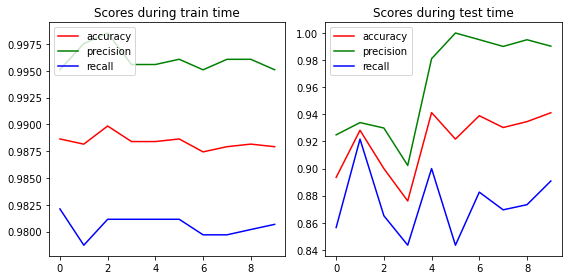

,accuracy,precision,recall,f1_macro
train,0.988347,0.996072,0.980563,0.988347
test,0.920597,0.964259,0.874680,0.920414


In [208]:
cv_RF, mean_scores_RF = cross_val(X_train_rf_bal, y_train_rf_bal, X_test_rf_bal, y_test_rf_bal, RandomForestClassifier() )
print(cv_RF)
plot_cross_val(cv_RF)
mean_scores_RF

SVD With 2000 components 

In [210]:

X_train_rf_bal, X_test_rf_bal, y_train_rf_bal, y_test_rf_bal= train_test_split(cos_sim_rf2,data_new['existence'], test_size=0.2, random_state=33)

In [211]:
X_train_rf_bal,y_train_rf_bal = RandomOverSampler(random_state = 21).fit_resample(X_train_rf_bal,y_train_rf_bal)

{'fit_time': array([36.36205339, 36.02114224, 35.94299698, 36.28916192, 35.64592838,
       35.75570035, 38.06585932, 37.44232798, 35.85381675, 36.41299605]), 'score_time': array([0.07619882, 0.07253385, 0.09510708, 0.09567809, 0.07073951,
       0.08137918, 0.08904409, 0.08077717, 0.07164955, 0.05028391]), 'test_accuracy': array([0.89347826, 0.93043478, 0.8826087 , 0.90217391, 0.9326087 ,
       0.91956522, 0.93899782, 0.93028322, 0.93246187, 0.93246187]), 'train_accuracy': array([0.98863636, 0.9881528 , 0.98984526, 0.98839458, 0.98839458,
       0.98863636, 0.98743051, 0.98791395, 0.98815567, 0.98791395]), 'test_precision': array([0.91705069, 0.92672414, 0.90740741, 0.9342723 , 0.97156398,
       1.        , 0.99509804, 0.99009901, 0.995     , 0.98058252]), 'train_precision': array([0.99461576, 0.99509564, 0.99705594, 0.99607073, 0.99461312,
       0.99558607, 0.99606299, 0.99606686, 0.99509804, 0.99509564]), 'test_recall': array([0.86521739, 0.93478261, 0.85217391, 0.86521739, 0.891

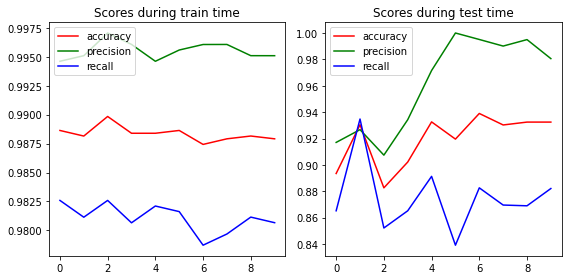

,accuracy,precision,recall,f1_macro
train,0.988347,0.995536,0.981095,0.988347
test,0.919507,0.961780,0.875109,0.919321


In [212]:
cv_RF, mean_scores_RF = cross_val(X_train_rf_bal, y_train_rf_bal, X_test_rf_bal, y_test_rf_bal, RandomForestClassifier() )
print(cv_RF)
plot_cross_val(cv_RF)
mean_scores_RF

In [200]:
from sklearn.metrics import make_scorer
from functools import partial
def cross_val(X_train, Y_train, X_test, Y_test, model, folds=10):
    #scoring = ["accuracy", "precision","recall","f1_macro"]
    scoring = {'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score,pos_label="Yes"),'recall': make_scorer(recall_score,pos_label="Yes"),'f1_macro': make_scorer(f1_score,average="macro",pos_label="Yes") }
    cv = cross_validate(model, X_train, Y_train, cv=folds,error_score="raise", return_train_score=True, scoring=scoring, n_jobs=-1)
    
    train_scores = []
    test_scores = []
    
    for metric in scoring:
        train_scores.append(np.mean(cv[f"train_{metric}"]))
        test_scores.append(np.mean(cv[f"test_{metric}"]))
        
    mean_scores = pd.DataFrame((train_scores, test_scores), columns=scoring, index=["train", "test"])
    
    return cv, mean_scores


In [ ]:
def plot_cross_val(cv, folds=10):    
    metrics = ["accuracy", "precision", "recall"]
    colors = ["r", "g", "b", "y"]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    
    for index, time_ in enumerate(["train", "test"]):
        for num, metric in enumerate(metrics):
            indexer = f"{time_}_{metric}"
            ax[index].plot(np.arange(folds), cv[indexer], color=colors[num])
        
        ax[index].legend(metrics, loc="upper left")
        ax[index].title.set_text(f"Scores during {time_} time")
    
    plt.tight_layout()
    plt.show()
